In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np

import ncar_jobqueue
from dask.distributed import Client

import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
import pandas as pd

style.use('default')
import matplotlib.path as mpath

In [2]:
case = 'g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.005'
path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/year_1'
variables = ['spC','coccoC','diatC','zoo1C','zoo2C','zoo3C','zoo4C','IFRAC','photoC_TOT_zint']
coords = {'x':'TLONG','y':'TLAT'}
keepthese = ['z_t','time_bound','TAREA','REGION_MASK', 'time'] + variables
keep_vars = keepthese +list(coords.values())+['dz','KMT']

#### get case

In [3]:
%%time
ds_list = []
print(f'reading {case}')
ds = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}/{case}.annual.{v}.????-????.nc'))       
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

reading g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.005
spC
coccoC
diatC
zoo1C
zoo2C
zoo3C
zoo4C
IFRAC
photoC_TOT_zint
CPU times: user 5.35 s, sys: 965 ms, total: 6.31 s
Wall time: 8.59 s


In [4]:
files

['/glade/scratch/kristenk/archive/g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.005/ocn/proc/tseries/year_1/g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.005.annual.photoC_TOT_zint.0062-0122.nc']

In [5]:
tmp = ds.zoo1C * 10.
ds['zoo1C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo2C * 10.
ds['zoo2C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo3C * 10.
ds['zoo3C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo4C * 10.
ds['zoo4C_zint'] = tmp.sum(dim='z_t_150m')

ds['zooC_TOT_zint'] = ds['zoo1C_zint'] + ds['zoo2C_zint'] + ds['zoo3C_zint'] + ds['zoo4C_zint']

tmp = ds.spC * 10.
ds['spC_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.diatC * 10.
ds['diatC_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.coccoC * 10.
ds['coccoC_zint'] = tmp.sum(dim='z_t_150m')

ds['phytoC_TOT_zint'] = ds['spC_zint'] + ds['diatC_zint'] + ds['coccoC_zint']

ds['diat_frac'] = ds['diatC_zint']/(ds.diatC_zint + ds.spC_zint + ds.coccoC_zint)

ds['big_zooC_zint'] = ds['zoo3C_zint'] + ds['zoo4C_zint']
ds['sm_zooC_zint'] = ds['zoo1C_zint'] + ds['zoo2C_zint']

In [6]:
ds = ds.drop(['spC','coccoC','diatC','zoo1C','zoo2C','zoo3C','zoo4C'])
# #ds  = ds.drop(['z_t','z_t_150m'])

In [7]:
ds_grid = pop_tools.get_grid('POP_gx1v7')

In [8]:
lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
area_m=ds_grid.TAREA * 1.e-4
depths=ds_grid.z_t * 0.01
tlen=len(ds.time)
years = np.arange(1958,1958+tlen,1)
years

array([1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968,
       1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
       1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018])

In [9]:
ds = ds.where(ds_grid.REGION_MASK>0)

In [10]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [11]:
ds

<xarray.Dataset>
Dimensions:          (nlat: 384, nlon: 320, time: 61, z_t: 60)
Coordinates:
  * time             (time) object 0062-12-31 00:00:00 ... 0122-12-31 00:00:00
    TLAT             (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG            (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * z_t              (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    KMT              (time, nlat, nlon) float64 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    TAREA            (time, nlat, nlon) float64 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    dz               (time, z_t, nlat, nlon) float32 dask.array<chunksize=(61, 60, 384, 320), meta=np.ndarray>
    IFRAC            (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    photoC_TOT_zint  (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    zoo1C_zint       (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    zoo2C_zint       (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    zoo3C_zint       (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    zoo4C_zint       (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    zooC_TOT_zint    (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    spC_zint         (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    diatC_zint       (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    coccoC_zint      (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    phytoC_TOT_zint  (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    diat_frac        (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    big_zooC_zint    (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    sm_zooC_zint     (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>

In [12]:
#redefine variable list
variables = ['phytoC_TOT_zint','zooC_TOT_zint','diatC_zint','big_zooC_zint','sm_zooC_zint','IFRAC']

In [13]:
len(variables)

6

In [14]:
st_dev_big_zooC = ds.big_zooC_zint.std(dim='time')
mean_big_zooC = ds.big_zooC_zint.mean(dim='time')
coeffvar_bigzooC = st_dev_big_zooC/mean_big_zooC

In [15]:
st_dev_sm_zooC = ds.sm_zooC_zint.std(dim='time')
mean_sm_zooC = ds.sm_zooC_zint.mean(dim='time')
coeffvar_smzooC = st_dev_sm_zooC/mean_sm_zooC

In [16]:
npp = ds.photoC_TOT_zint * 0.01 * 86400. #mmol/m2/d
st_dev_NPP = npp.std(dim='time')
mean_NPP = npp.mean(dim='time')
coeffvar_NPP = st_dev_NPP/mean_NPP

In [17]:
st_dev_ice = ds.IFRAC.std(dim='time')
mean_ice = ds.IFRAC.mean(dim='time')
coeffvar_ice = st_dev_ice/mean_ice

In [18]:
import cmocean

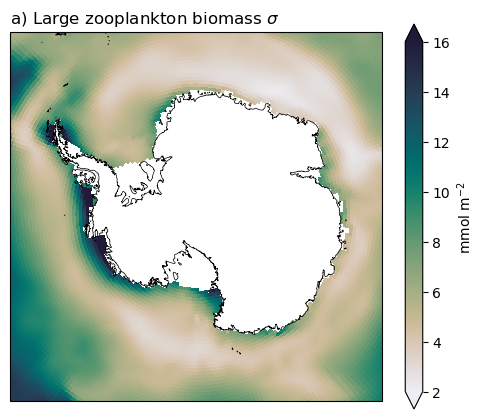

In [19]:
fig = plt.figure(figsize=(6,5))


#----------
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('a) Large zooplankton biomass ${\sigma}$',loc='left')
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())


# #################### make it a circle
# theta = np.linspace(0, 2*np.pi, 100)
# center, radius = [0.5, 0.5], 0.5
# verts = np.vstack([np.sin(theta), np.cos(theta)]).T
# circle = mpath.Path(verts * radius + center)

# ax.set_boundary(circle, transform=ax.transAxes)
# #################### end circle

ax.coastlines('10m',linewidth=0.5)
lon, lat, field = adjust_pop_grid(lons, lats, st_dev_big_zooC)
pc=ax.pcolormesh(lon, lat, field, 
                 vmin=2, vmax=16, 
                 cmap=cmocean.cm.rain,
                 transform=ccrs.PlateCarree())


cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='mmol m$^{-2}$')

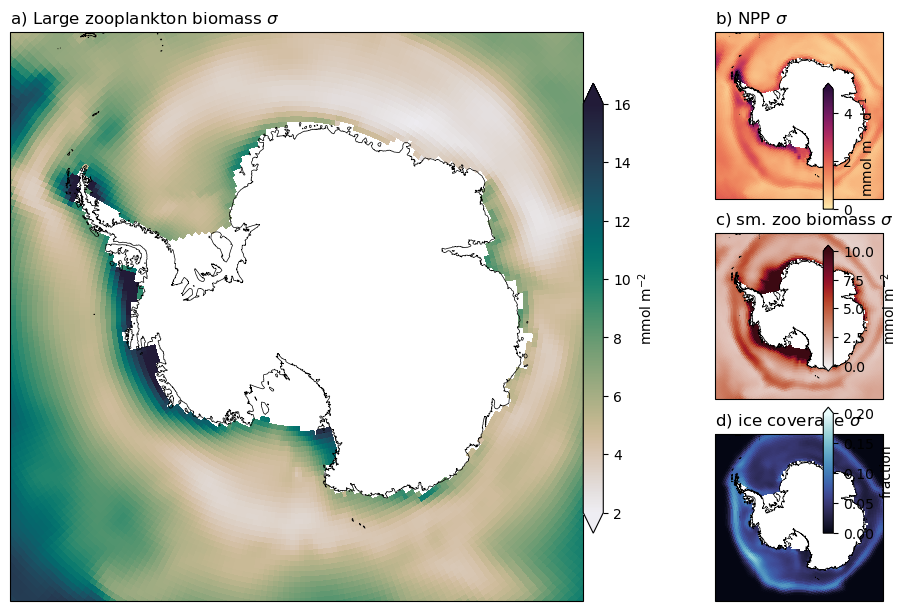

In [20]:
fig = plt.figure(constrained_layout=True,figsize=(10,6))
ax = fig.add_gridspec(3, 4)


#########################
ax1 = fig.add_subplot(ax[0:3,0:3], projection=ccrs.SouthPolarStereo())

ax1.set_title('a) Large zooplankton biomass ${\sigma}$',loc='left')
ax1.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
ax1.coastlines('10m',linewidth=0.5)
lon, lat, field = adjust_pop_grid(lons, lats, st_dev_big_zooC)
pc=ax1.pcolormesh(lon, lat, field, 
                 vmin=2, vmax=16, 
                 cmap=cmocean.cm.rain,
                 transform=ccrs.PlateCarree())

#cbar1 = fig.colorbar(pc, ax=ax1,extend='both',label='mmol m$^{-2}$')
cbar_ax = fig.add_axes([0.66, 0.12, 0.02, 0.75])
cbar1 = fig.colorbar(pc, extend='both', cax=cbar_ax, label='mmol m$^{-2}$');
#########################
ax1 = fig.add_subplot(ax[0,3], projection=ccrs.SouthPolarStereo())

ax1.set_title('b) NPP ${\sigma}$',loc='left')
ax1.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
ax1.coastlines('10m',linewidth=0.5)
lon, lat, field = adjust_pop_grid(lons, lats, st_dev_NPP)
pc=ax1.pcolormesh(lon, lat, field, 
                 vmin=0, vmax=5, 
                 cmap=cmocean.cm.matter,
                 transform=ccrs.PlateCarree())

#cbar1 = fig.colorbar(pc, ax=ax1,extend='both',label='mmol m$^{-2}$')
cbar_ax = fig.add_axes([0.9, 0.66, 0.01, 0.21])
cbar1 = fig.colorbar(pc, extend='max', cax=cbar_ax, label='mmol m$^{-2}$ d$^{-1}$');
#########################
ax1 = fig.add_subplot(ax[1,3], projection=ccrs.SouthPolarStereo())
ax1.set_title('c) sm. zoo biomass ${\sigma}$',loc='left')
ax1.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
ax1.coastlines('10m',linewidth=0.5)
lon, lat, field = adjust_pop_grid(lons, lats, st_dev_sm_zooC)
pc=ax1.pcolormesh(lon, lat, field, 
                 vmin=0,vmax=10 ,
                 cmap=cmocean.cm.amp,
                 transform=ccrs.PlateCarree())

#cbar1 = fig.colorbar(pc, ax=ax1,extend='both',label='mmol m$^{-2}$')
cbar_ax = fig.add_axes([0.9, 0.39, 0.01, 0.21])
cbar1 = fig.colorbar(pc, extend='both', cax=cbar_ax, label='mmol m$^{-2}$');
#########################

ax1 = fig.add_subplot(ax[2,3], projection=ccrs.SouthPolarStereo())

ax1.set_title('d) ice coverage ${\sigma}$',loc='left')
ax1.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
ax1.coastlines('10m',linewidth=0.5)
lon, lat, field = adjust_pop_grid(lons, lats, st_dev_ice)
pc=ax1.pcolormesh(lon, lat, field, 
                 vmin=0,vmax=0.2,
                 cmap=cmocean.cm.ice,
                 transform=ccrs.PlateCarree())
cbar_ax = fig.add_axes([0.9, 0.12, 0.01, 0.21])
cbar1 = fig.colorbar(pc, extend='max', cax=cbar_ax, label='fraction');
#cbar1 = fig.colorbar(pc, ax=ax1,extend='both',label='mmol m$^{-2}$')

fig.savefig('/glade/work/kristenk/figs/Antarctic_ecosys_stdev.png', bbox_inches='tight', dpi=300, format='pdf');

In [21]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

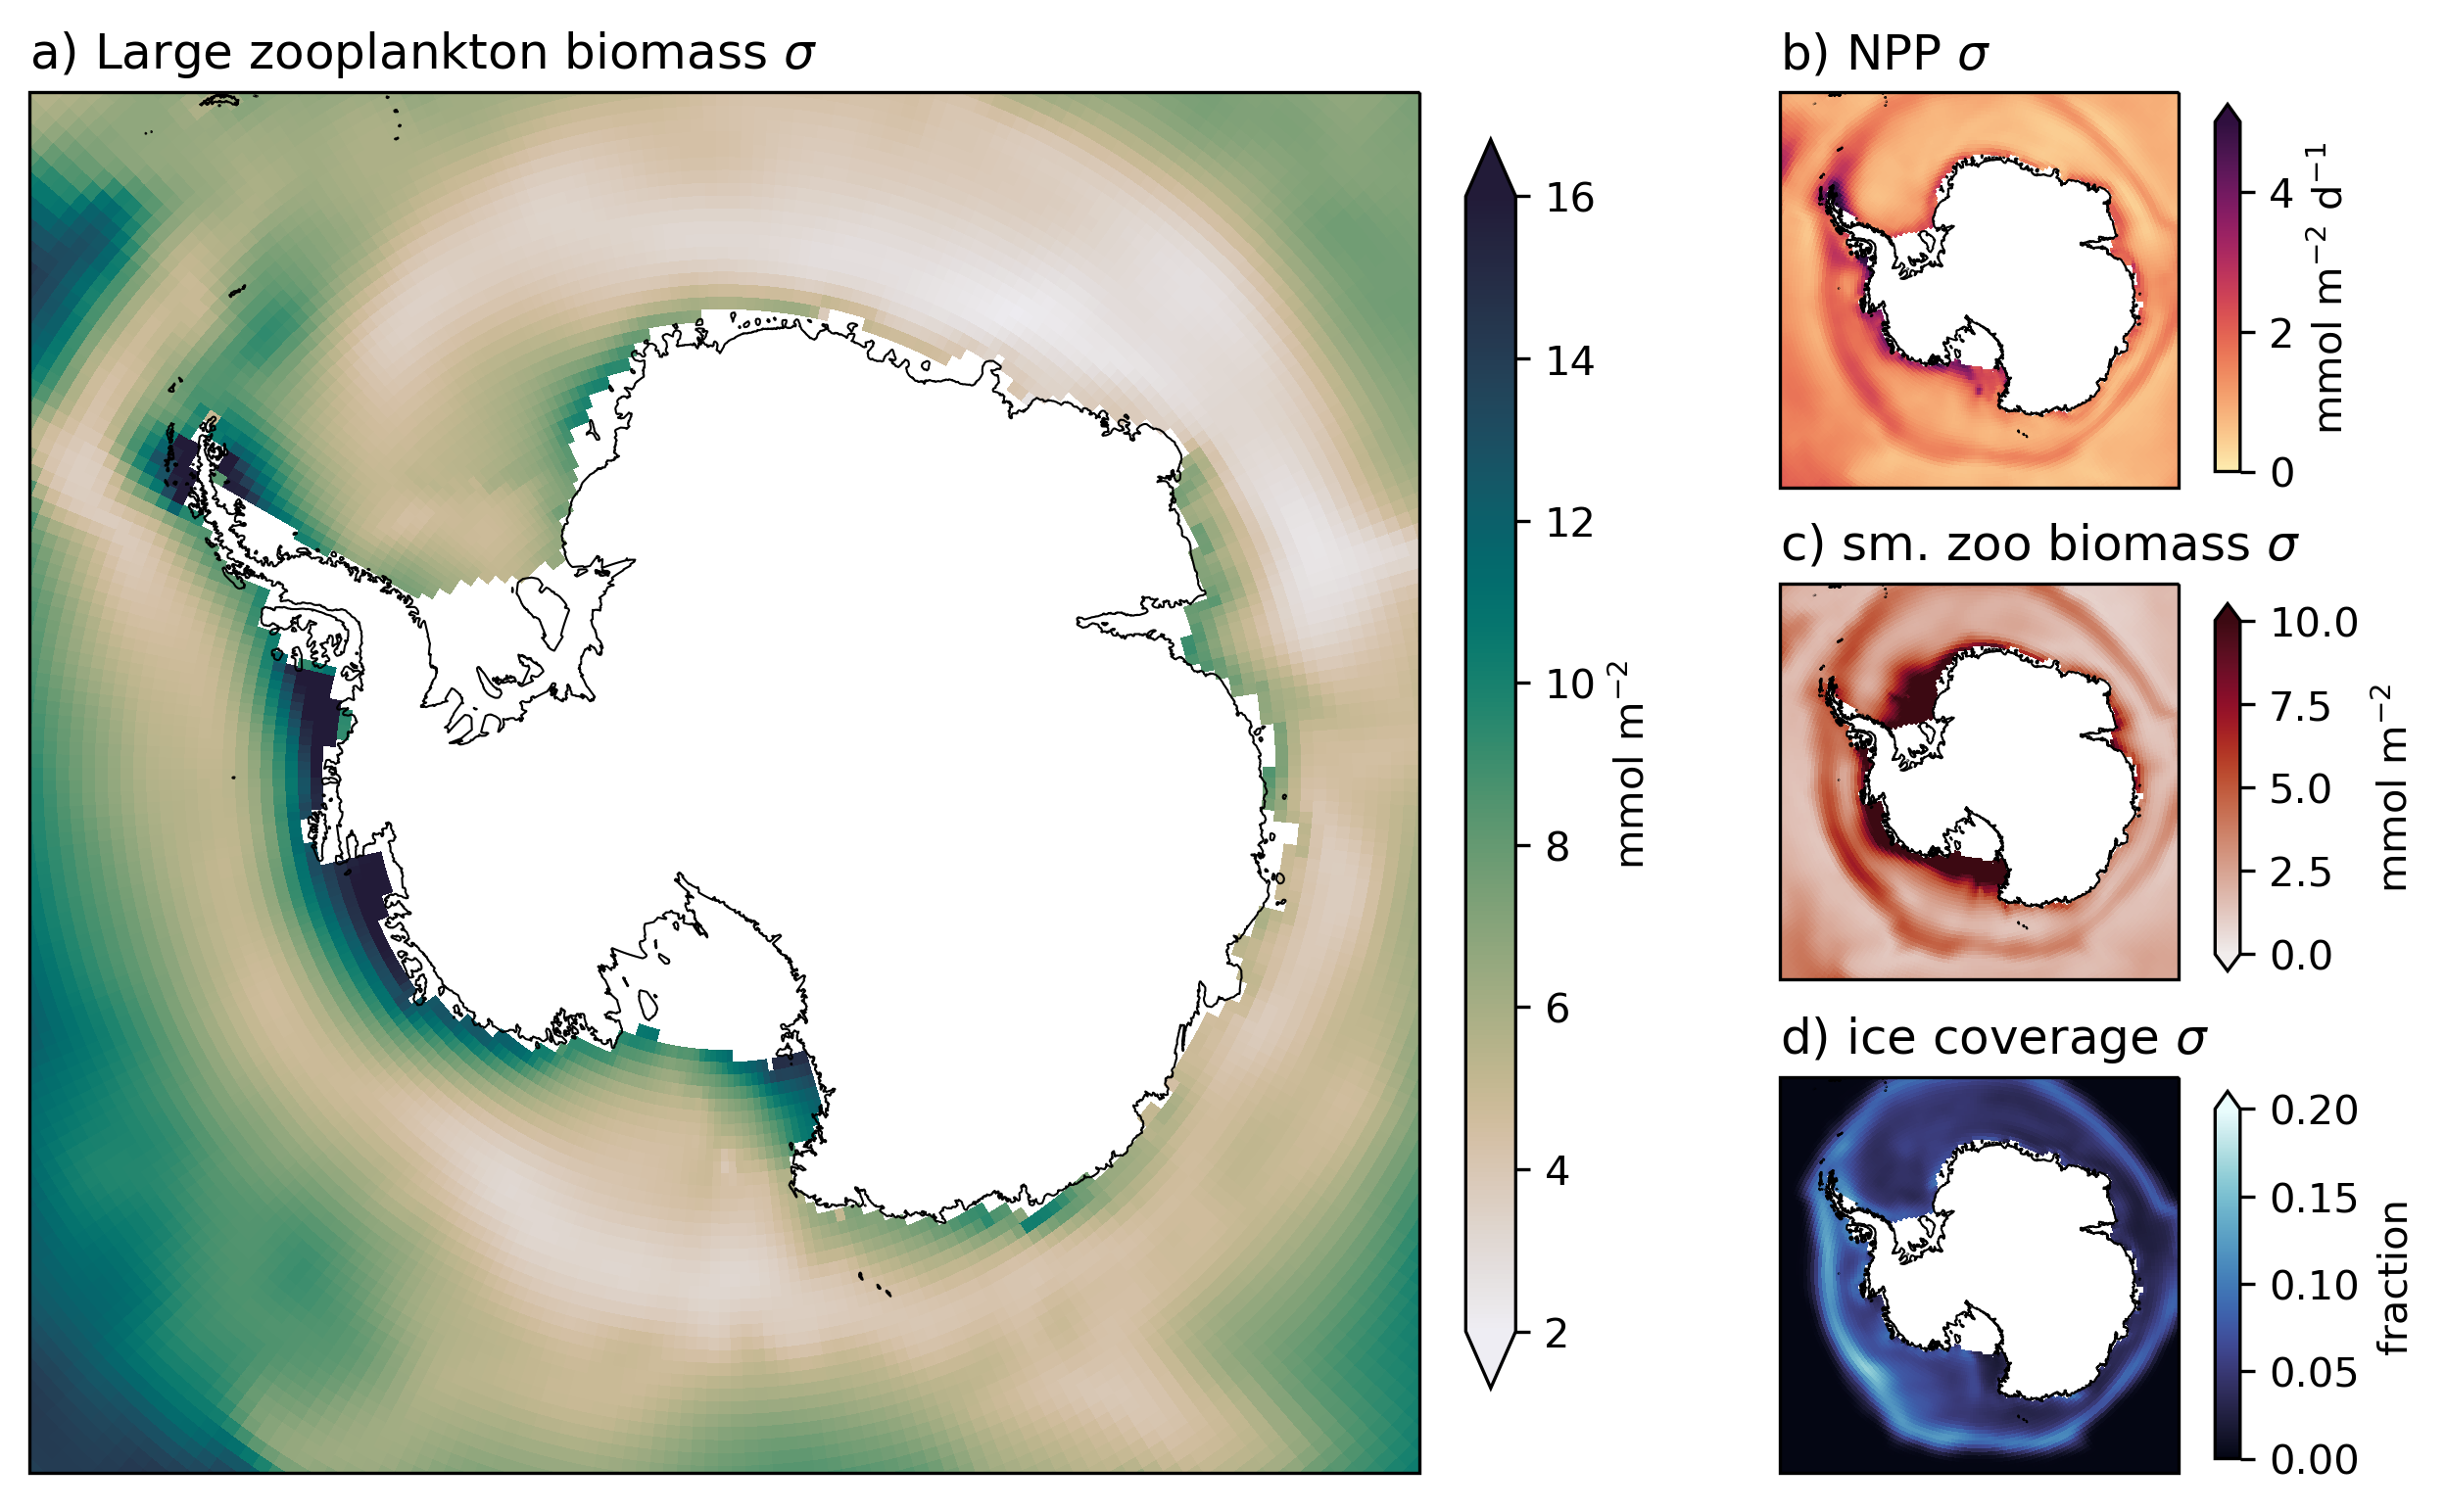

In [22]:
fig = plt.figure(constrained_layout=True,figsize=(8.5,5))
ax = fig.add_gridspec(3, 4)


#########################
ax1 = fig.add_subplot(ax[0:3,0:3], projection=ccrs.SouthPolarStereo())

ax1.set_title('a) Large zooplankton biomass ${\sigma}$',loc='left')
ax1.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
ax1.coastlines('10m',linewidth=0.5)
lon, lat, field = adjust_pop_grid(lons, lats, st_dev_big_zooC)
pc=ax1.pcolormesh(lon, lat, field, 
                 vmin=2, vmax=16, 
                 cmap=cmocean.cm.rain,
                 transform=ccrs.PlateCarree())

#cbar1 = fig.colorbar(pc, ax=ax1,extend='both',label='mmol m$^{-2}$')
cbar_ax = fig.add_axes([0.67, 0.066, 0.02, 0.85])
cbar1 = fig.colorbar(pc, extend='both', cax=cbar_ax, label='mmol m$^{-2}$');
#########################
ax1 = fig.add_subplot(ax[0,3], projection=ccrs.SouthPolarStereo())

ax1.set_title('b) NPP ${\sigma}$',loc='left')
ax1.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
ax1.coastlines('10m',linewidth=0.5)
lon, lat, field = adjust_pop_grid(lons, lats, st_dev_NPP)
pc=ax1.pcolormesh(lon, lat, field, 
                 vmin=0, vmax=5, 
                 cmap=cmocean.cm.matter,
                 transform=ccrs.PlateCarree())

#cbar1 = fig.colorbar(pc, ax=ax1,extend='both',label='mmol m$^{-2}$')
cbar_ax = fig.add_axes([0.97, 0.69, 0.01, 0.25])
cbar1 = fig.colorbar(pc, extend='max', cax=cbar_ax, label='mmol m$^{-2}$ d$^{-1}$');
#########################
ax1 = fig.add_subplot(ax[1,3], projection=ccrs.SouthPolarStereo())
ax1.set_title('c) sm. zoo biomass ${\sigma}$',loc='left')
ax1.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
ax1.coastlines('10m',linewidth=0.5)
lon, lat, field = adjust_pop_grid(lons, lats, st_dev_sm_zooC)
pc=ax1.pcolormesh(lon, lat, field, 
                 vmin=0,vmax=10 ,
                 cmap=cmocean.cm.amp,
                 transform=ccrs.PlateCarree())

#cbar1 = fig.colorbar(pc, ax=ax1,extend='both',label='mmol m$^{-2}$')
cbar_ax = fig.add_axes([0.97, 0.35, 0.01, 0.25])
cbar1 = fig.colorbar(pc, extend='both', cax=cbar_ax, label='mmol m$^{-2}$');
#########################

ax1 = fig.add_subplot(ax[2,3], projection=ccrs.SouthPolarStereo())

ax1.set_title('d) ice coverage ${\sigma}$',loc='left')
ax1.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
ax1.coastlines('10m',linewidth=0.5)
lon, lat, field = adjust_pop_grid(lons, lats, st_dev_ice)
pc=ax1.pcolormesh(lon, lat, field, 
                 vmin=0,vmax=0.2,
                 cmap=cmocean.cm.ice,
                 transform=ccrs.PlateCarree())
cbar_ax = fig.add_axes([0.97, 0.018, 0.01, 0.25])
cbar1 = fig.colorbar(pc, extend='max', cax=cbar_ax, label='fraction');
#cbar1 = fig.colorbar(pc, ax=ax1,extend='both',label='mmol m$^{-2}$')

#fig.savefig('/glade/work/kristenk/figs/Antarctic_ecosys_stdev.png', bbox_inches='tight', dpi=300, format='pdf');
fig.savefig('/glade/work/kristenk/figs/Antarctic_ecosys_stdev.png', bbox_inches='tight', dpi=300, format='png');

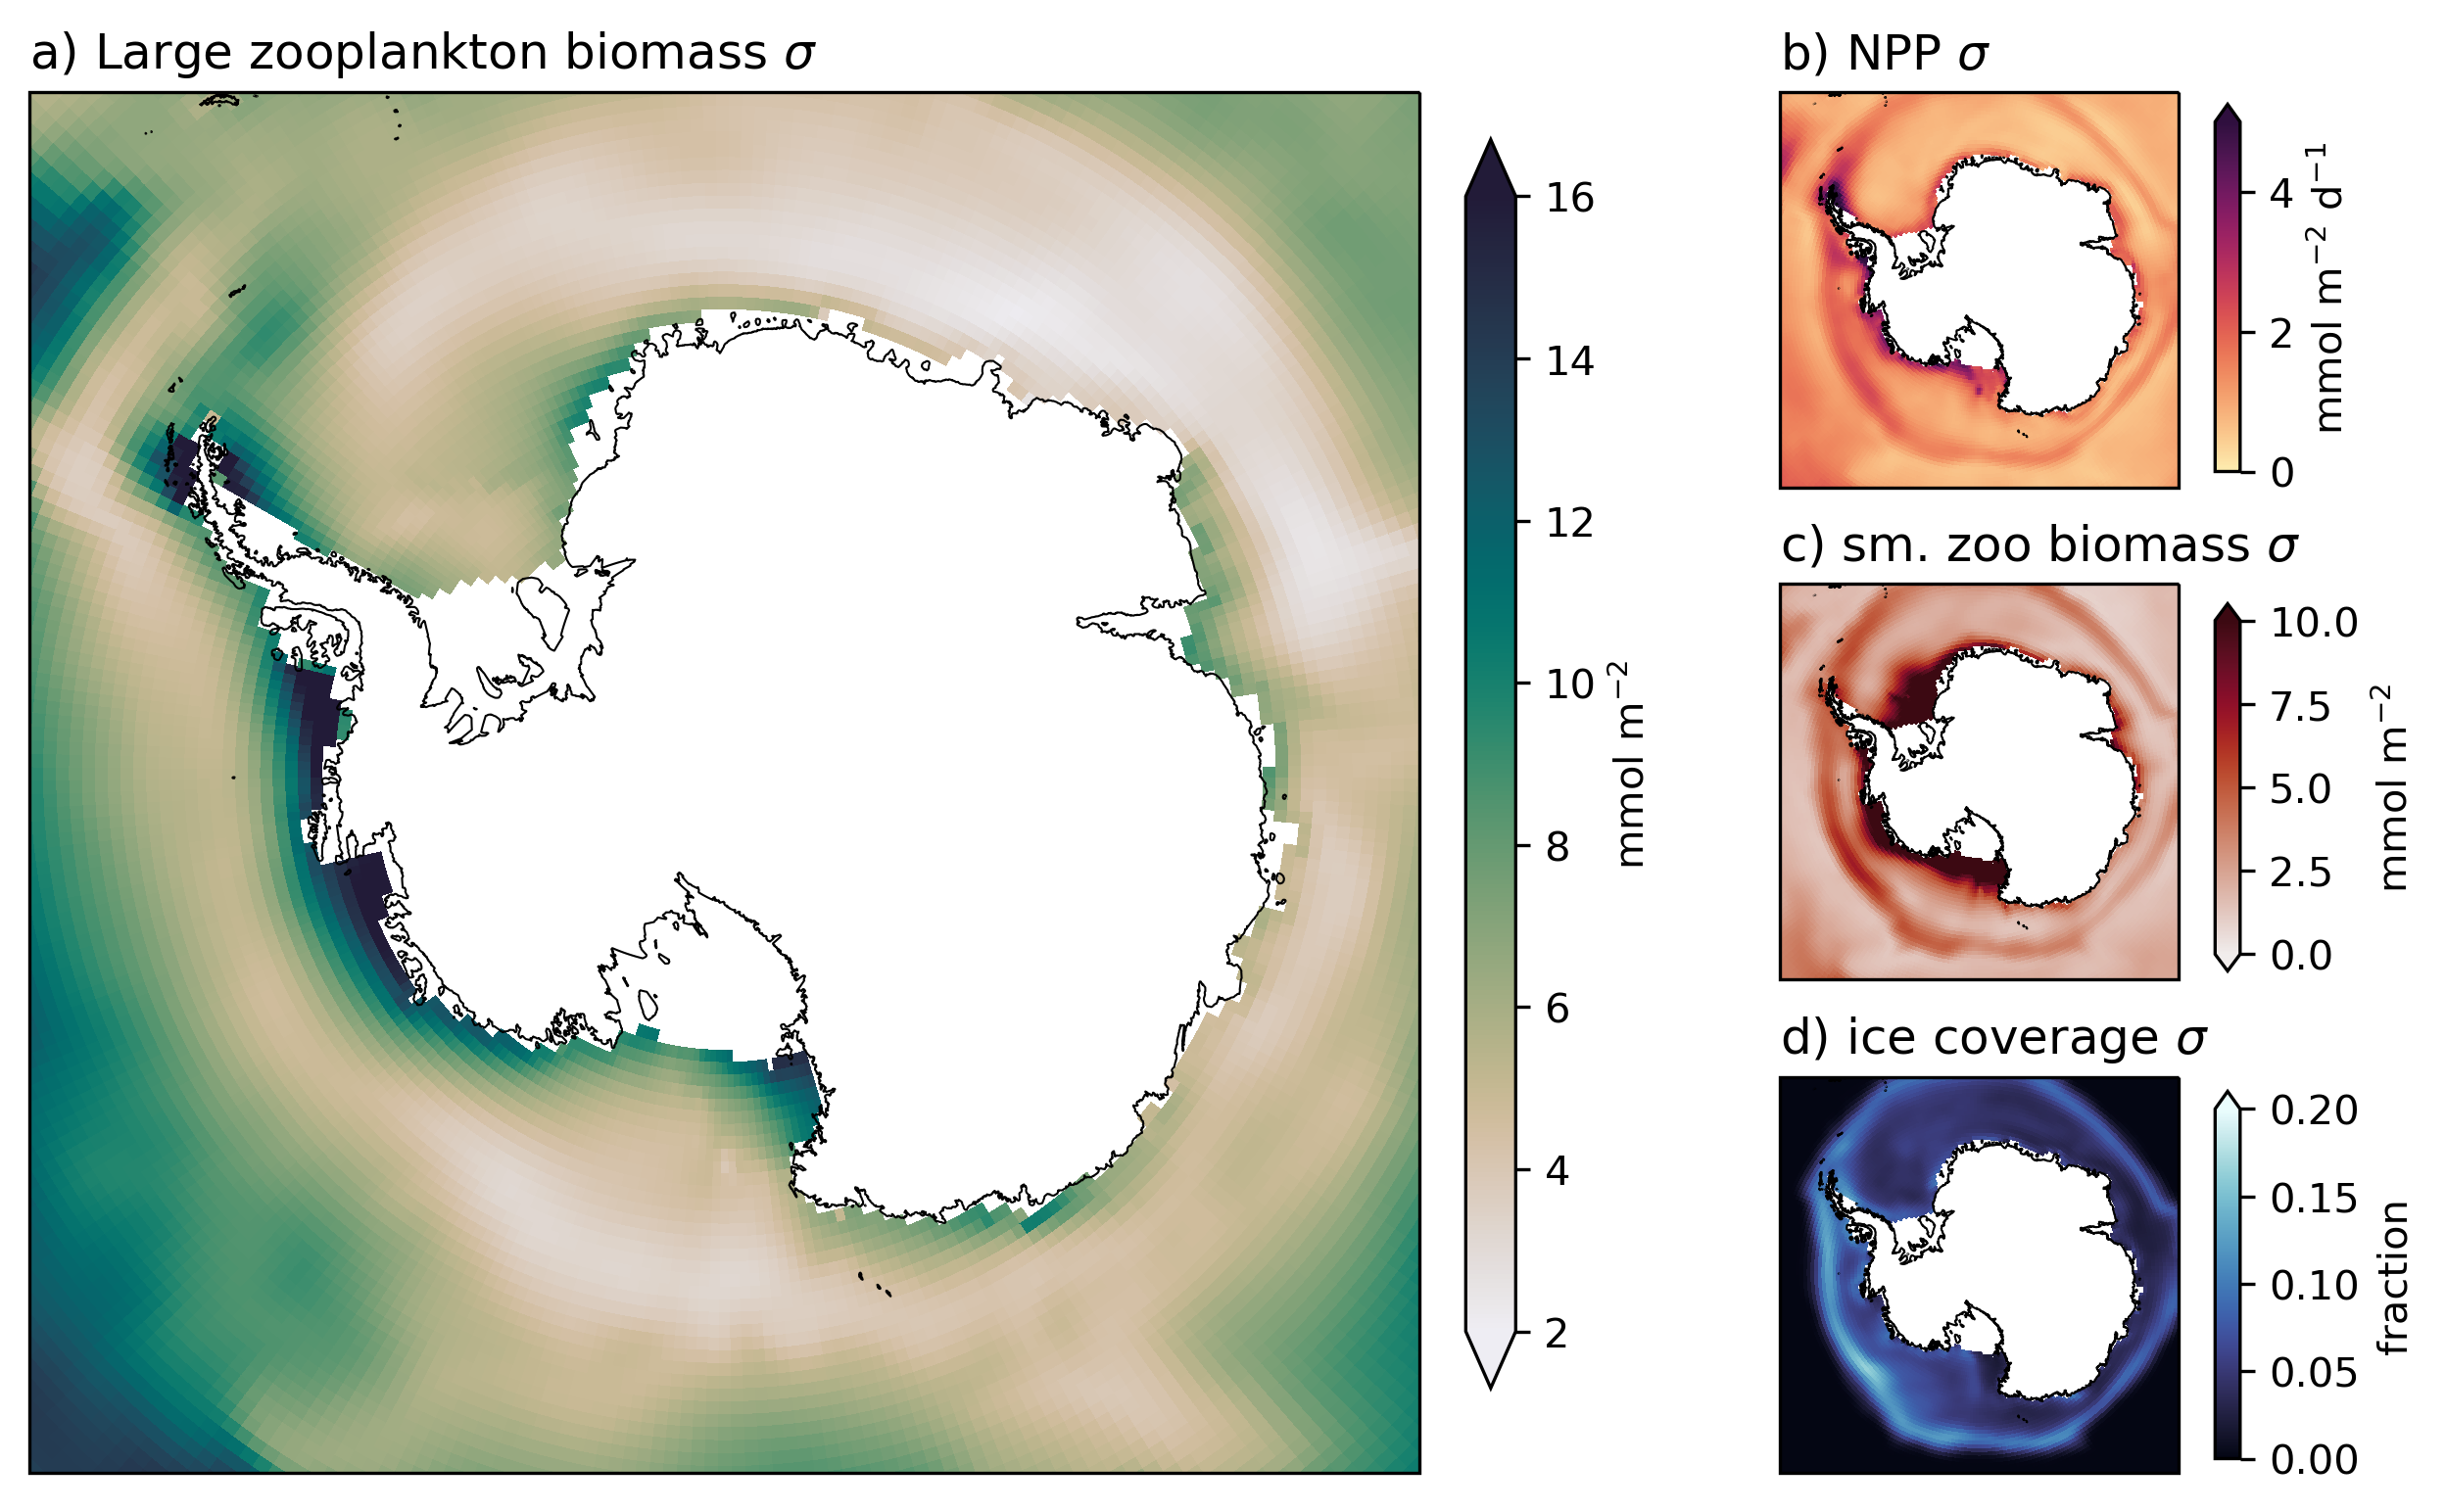

In [23]:
fig = plt.figure(constrained_layout=True,figsize=(8.5,5))
ax = fig.add_gridspec(3, 4)


#########################
ax1 = fig.add_subplot(ax[0:3,0:3], projection=ccrs.SouthPolarStereo())

ax1.set_title('a) Large zooplankton biomass ${\sigma}$',loc='left')
ax1.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
ax1.coastlines('10m',linewidth=0.5)
lon, lat, field = adjust_pop_grid(lons, lats, st_dev_big_zooC)
pc=ax1.pcolormesh(lon, lat, field, 
                 vmin=2, vmax=16, 
                 cmap=cmocean.cm.rain,
                 transform=ccrs.PlateCarree())

#cbar1 = fig.colorbar(pc, ax=ax1,extend='both',label='mmol m$^{-2}$')
cbar_ax = fig.add_axes([0.67, 0.066, 0.02, 0.85])
cbar1 = fig.colorbar(pc, extend='both', cax=cbar_ax, label='mmol m$^{-2}$');
#########################
ax1 = fig.add_subplot(ax[0,3], projection=ccrs.SouthPolarStereo())

ax1.set_title('b) NPP ${\sigma}$',loc='left')
ax1.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
ax1.coastlines('10m',linewidth=0.5)
lon, lat, field = adjust_pop_grid(lons, lats, st_dev_NPP)
pc=ax1.pcolormesh(lon, lat, field, 
                 vmin=0, vmax=5, 
                 cmap=cmocean.cm.matter,
                 transform=ccrs.PlateCarree())

#cbar1 = fig.colorbar(pc, ax=ax1,extend='both',label='mmol m$^{-2}$')
cbar_ax = fig.add_axes([0.97, 0.69, 0.01, 0.25])
cbar1 = fig.colorbar(pc, extend='max', cax=cbar_ax, label='mmol m$^{-2}$ d$^{-1}$');
#########################
ax1 = fig.add_subplot(ax[1,3], projection=ccrs.SouthPolarStereo())
ax1.set_title('c) sm. zoo biomass ${\sigma}$',loc='left')
ax1.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
ax1.coastlines('10m',linewidth=0.5)
lon, lat, field = adjust_pop_grid(lons, lats, st_dev_sm_zooC)
pc=ax1.pcolormesh(lon, lat, field, 
                 vmin=0,vmax=10 ,
                 cmap=cmocean.cm.amp,
                 transform=ccrs.PlateCarree())

#cbar1 = fig.colorbar(pc, ax=ax1,extend='both',label='mmol m$^{-2}$')
cbar_ax = fig.add_axes([0.97, 0.35, 0.01, 0.25])
cbar1 = fig.colorbar(pc, extend='both', cax=cbar_ax, label='mmol m$^{-2}$');
#########################

ax1 = fig.add_subplot(ax[2,3], projection=ccrs.SouthPolarStereo())

ax1.set_title('d) ice coverage ${\sigma}$',loc='left')
ax1.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
ax1.coastlines('10m',linewidth=0.5)
lon, lat, field = adjust_pop_grid(lons, lats, st_dev_ice)
pc=ax1.pcolormesh(lon, lat, field, 
                 vmin=0,vmax=0.2,
                 cmap=cmocean.cm.ice,
                 transform=ccrs.PlateCarree())
cbar_ax = fig.add_axes([0.97, 0.018, 0.01, 0.25])
cbar1 = fig.colorbar(pc, extend='max', cax=cbar_ax, label='fraction');
#cbar1 = fig.colorbar(pc, ax=ax1,extend='both',label='mmol m$^{-2}$')

#fig.savefig('/glade/work/kristenk/figs/Antarctic_ecosys_stdev.png', bbox_inches='tight', dpi=300, format='pdf');
fig.savefig('/glade/work/kristenk/figs/Antarctic_ecosys_stdev.eps', bbox_inches='tight', format='eps');